In [72]:
########### Visualizing dyad. ###########

In [73]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import skimage
import numpy as np
from typing import List
import random
from tqdm import tqdm
import scipy.io as sio

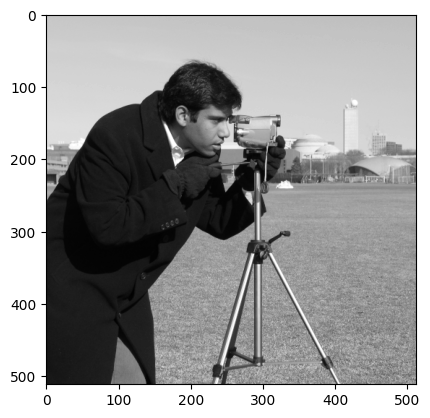

(512, 512), (512,), (512, 512)
(512, 512)


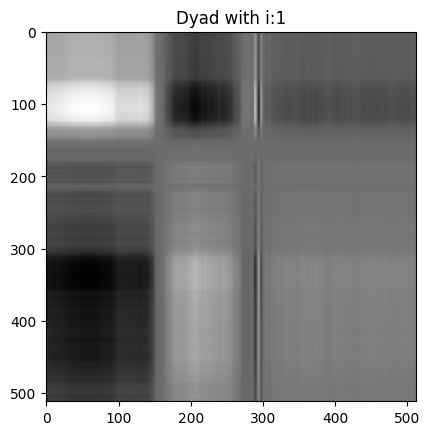

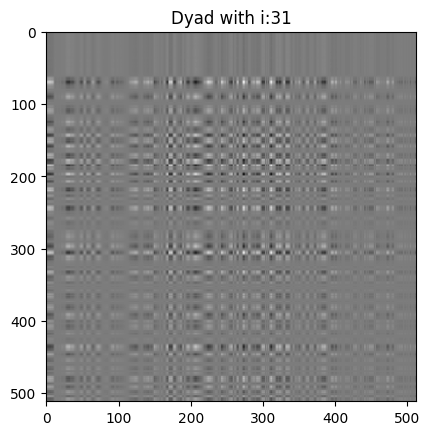

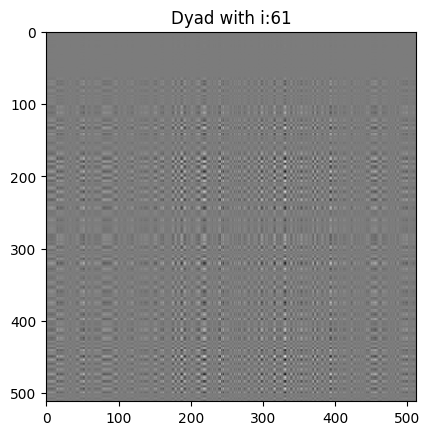

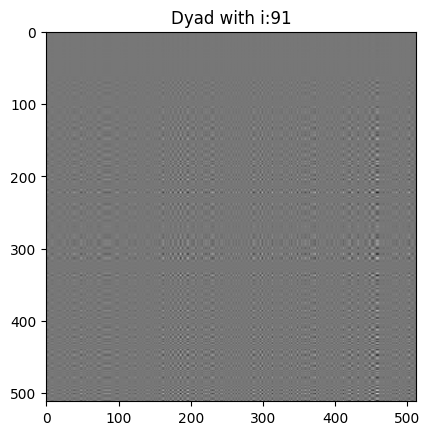

In [307]:
#### ESERCIZIO 1 ####
img = skimage.data.camera()
plt.imshow(img, cmap="gray")
plt.show()

U, s, VT = np.linalg.svd(img)
print(f"{U.shape}, {s.shape}, {VT.shape}")
S = np.diag(s)
print(S.shape)


"""
Se X è nxm: U deve avere la forma nxn, S nxm e VT mxm così otteniamo nxm come output.
Quindi quando facciamo slicing lasciamo la dimesione originale di righe a U, e la dimensione originale di colonne a VT
in  questo modo continuiamo ad avere in output una matrice nxm.
In questo caso prendiamo solamente i e non :i perchè volgiamo visualizzare solamente il valore del dyad per quello specifico valore
di i e non la sommatoria dei dyad fino a i.
"""
for i in np.arange(1, 100, 30):
  plt.imshow((U[:, i:i+1] @ VT[i:i+1, :]) *S[i, i], cmap="gray")
  plt.title(f'Dyad with i:{ i}')
  plt.show()



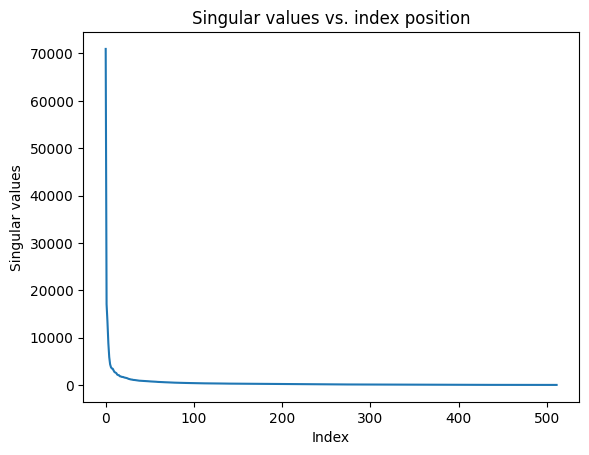

In [308]:
plt.plot(range(len(s)),s)
plt.title('Singular values vs. index position')
plt.xlabel('Index')
plt.ylabel('Singular values')
plt.show()

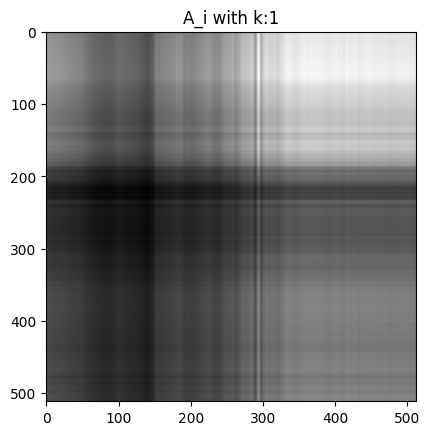

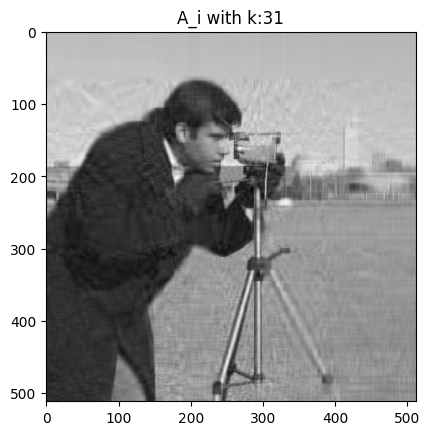

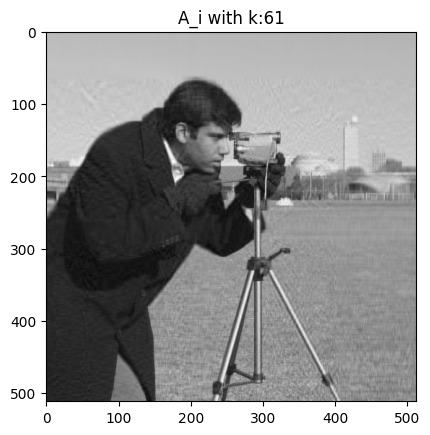

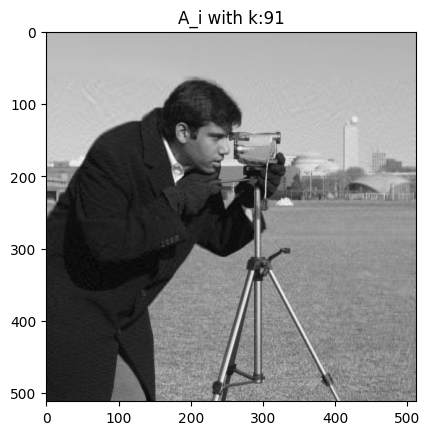

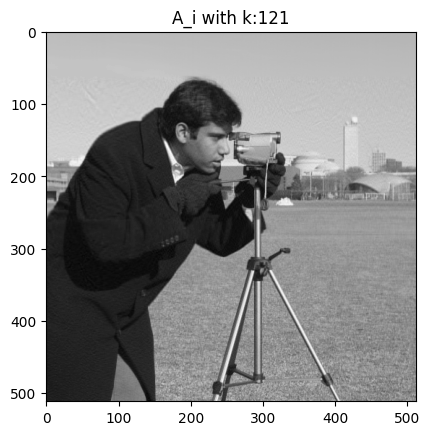

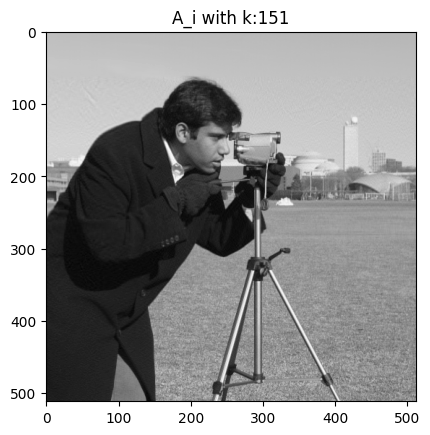

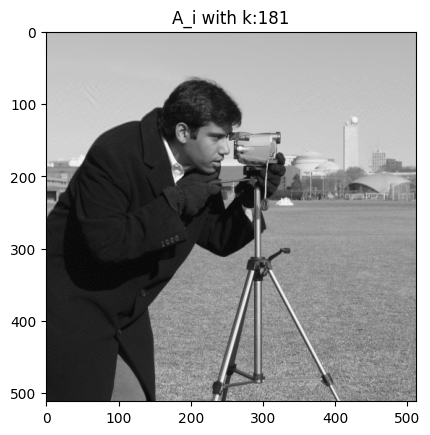

In [309]:
"""
Se X è nxm: U deve avere la forma nxn, S nxm e VT mxm così otteniamo nxm come output.
Quindi quando facciamo slicing lasciamo la dimesione originale di righe a U, e la dimensione originale di colonne a VT
in  questo modo continuiamo ad avere in output una matrice nxm.
"""
for i in np.arange(1, 200, 30):
  plt.imshow(U[:, :i] @ S[:i, :i] @ VT[:i, :], cmap="gray")
  plt.title(f'A_i with k:{ i}')
  plt.show()

512 512


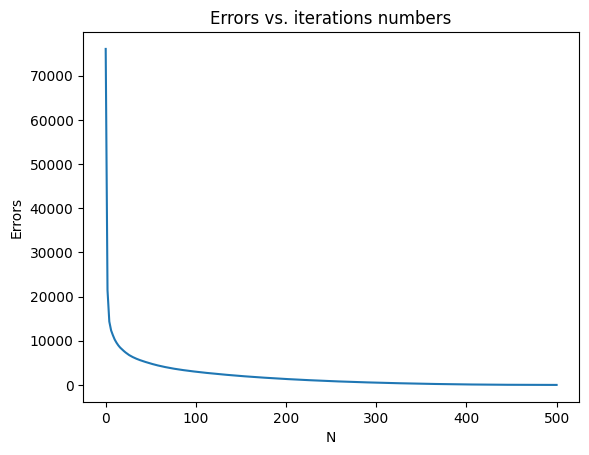

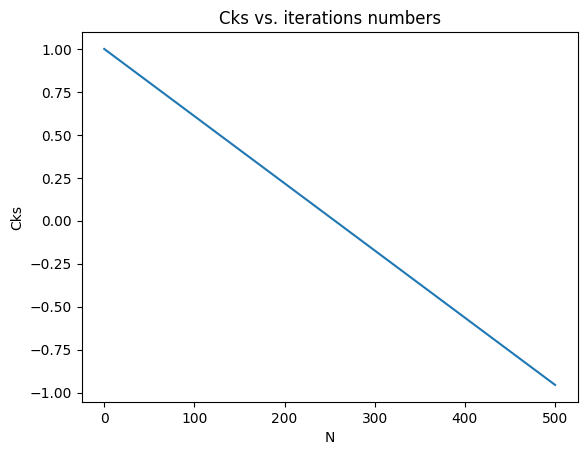

Approximation error at k=216: 810.6223365797822


In [ ]:
nums = np.arange(0, 501, 2)
errs, cks = [], []
n, m = img.shape
print(m, n)
for k in nums:
  X_k = U[:, :k] @ S[:k, :k] @ VT[:k, :]
  errs.append(np.linalg.norm((img - X_k), 'fro'))
  # Fattore di compressione
  cks.append(1-((k*(m + n + 1) / (m*n))))
plt.plot(nums, errs)
plt.title('Errors vs. iterations numbers')
plt.xlabel('N')
plt.ylabel('Errors')
plt.show()

plt.plot(nums, cks)
plt.title('Cks vs. iterations numbers')
plt.xlabel('N')
plt.ylabel('Cks')
plt.show()


X_k = U[:, :256] @ S[:256, :256] @ VT[:256, :]
print(f"Approximation error at k=216: {np.linalg.norm((img - X_k), 'fro')}")

In [ ]:
########### Classification of MNIST Digits with SVD Decomposition. ###########

In [112]:
#data = sio.loadmat('MNIST.mat')
data = pd.read_csv(r'sample_data/mnist_test.csv')

In [239]:
label = np.array(data[data.columns[0]])
x_data = np.array(data.drop(data.columns[0], axis=1)).T
"""
label = data['I']
print(type(label))
x_data = data['X']
print(type(x_data))"""
print(x_data.shape, label.shape)
numbers = [1, 4]

(784, 1000) (1000,)


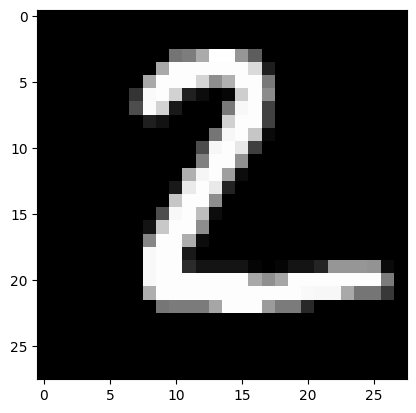

In [114]:
def visualize_vector(vec):
  img = vec.reshape(28, 28)
  plt.imshow(img, cmap="gray")
visualize_vector(x_data[:, 0])

In [211]:
"""
  Given a dataset x of feature, a dataset y of labels and a list of integers
  the function return a dataset y containing only labels equals to the integer
  present in the list and their corresponding feature.
"""
def filter_data(x, y, filter: List[int]):
  y = y.ravel() # Return a contiguous flattened array.

  # Create a boolean mask for rows where y is 3 or 4
  mask = False
  for elem in filter:
    mask = mask | (y == elem)

  # Use the mask to filter x and y
  filtered_x = x[:, mask]
  filtered_y = y[mask]

  # If you want to reshape filtered_y back to (1, N) where N is the number of selected rows
  filtered_y = filtered_y.reshape(1, -1)

  return filtered_x, filtered_y

fil_x, fil_y = filter_data(x_data, label, numbers)
print(np.unique(fil_y))

[2 3 4]


In [212]:
def split_dataset(x_dataset, label_dataset, train_rateo):
  dataset = np.concatenate((x_dataset, label_dataset), axis=0)
  train_split = int(len(dataset[0])*train_rateo)
  return dataset[:, :train_split][:-1], dataset[:, :train_split][-1], dataset[:, train_split:][:-1], dataset[:, train_split:][-1]

x_train, y_train, x_test, y_test = split_dataset(fil_x, fil_y, 0.8)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(np.unique(y_test))

(784, 243) (243,) (784, 61) (61,)
[2 3 4]


In [213]:
"""
  Given a dataset x of feature, a dataset y containing N unique labels and an
  integer train_rateo 0<=train_rateo<=1 the function return a list of N dataset
  x,y each containing only one unique label.
"""
def separate_dataset(x, y):
  unique = np.unique(y)
  y = y.ravel()
  mask_list, c_list, yc_list = [], [], []
  for n in unique:
    mask_list.append(y == n)

  for mask in mask_list:
    c_list.append(x[:, mask])
    yc_list.append(y[mask].reshape(1, -1))

  return c_list, yc_list

c_list, y_list = separate_dataset(x_train, y_train)

In [83]:
def get_u_list(c_list):
  return [np.linalg.svd(c, full_matrices=False)[0] for c in c_list]

In [84]:
def classify_digit(u_list, y, target, c_label):
  dist_list = []

  for U in u_list:
    y_orto = U@(U.T@y) #U columns ortonormal base used to project y in the columns of X space
    dist_list.append(np.linalg.norm(y - y_orto, 2))

  res = c_label[np.argmin(dist_list)]
  if res == target:
    return True
  else:
    return False

In [116]:
def test_svd_accuracy(numbers):
  fil_x, fil_y = filter_data(x_data, label, numbers)
  x_train, y_train, x_test, y_test = split_dataset(fil_x, fil_y, 0.7)
  c_list, y_list = separate_dataset(x_train, y_train)
  u_list = get_u_list(c_list)

  correct = 0
  for i in range(len(x_test[0])):
    if classify_digit(u_list, x_train[:, i].T, y_train[i], np.unique(y_train)):
      correct += 1
  print(f"Accuracy on train for {numbers}: {correct/len(x_test[0].T)}")

  correct = 0
  for i in range(len(x_test[0])):
    if classify_digit(u_list, x_test[:, i].T, y_test[i], np.unique(y_test)):
      correct += 1
  print(f"Accuracy on test for {numbers}: {correct/len(x_test[0].T)}")
  print("-------------------------------")

In [171]:
print("        ##### TEST WITH 28x28 MNIST #####", end='\n\n')
test_svd_accuracy([3, 4])
test_svd_accuracy([1, 7])
test_svd_accuracy([1, 5, 9])
test_svd_accuracy([0, 3, 8])

        ##### TEST WITH 28x28 MNIST #####

Accuracy on train for [3, 4]: 1.0
Accuracy on test for [3, 4]: 1.0
-------------------------------
Accuracy on train for [1, 7]: 1.0
Accuracy on test for [1, 7]: 1.0
-------------------------------
Accuracy on train for [1, 5, 9]: 1.0
Accuracy on test for [1, 5, 9]: 0.9838709677419355
-------------------------------
Accuracy on train for [0, 3, 8]: 1.0
Accuracy on test for [0, 3, 8]: 0.9833333333333333
-------------------------------


In [ ]:
print("        ##### TEST WITH 16x16 MNIST #####", end='\n\n')
test_svd_accuracy([3, 4])
test_svd_accuracy([1, 7])
test_svd_accuracy([1, 5, 9])
test_svd_accuracy([0, 3, 8])

        ##### TEST WITH 16x16 MNIST #####

Accuracy on train for [3, 4]: 1.0
Accuracy on test for [3, 4]: 0.9803921568627451
-------------------------------
Accuracy on train for [1, 7]: 0.9761904761904762
Accuracy on test for [1, 7]: 0.8690476190476191
-------------------------------
Accuracy on train for [1, 5, 9]: 0.9894736842105263
Accuracy on test for [1, 5, 9]: 0.8736842105263158
-------------------------------
Accuracy on train for [0, 3, 8]: 0.7478991596638656
Accuracy on test for [0, 3, 8]: 0.46218487394957986
-------------------------------


In [ ]:
####### Clustering with PCA #######

In [356]:
df = pd.read_csv(r'sample_data/mnist_test.csv')
display(df)
df = df.to_numpy().T
#plt.imshow(df.head(1).drop('7', axis=1).to_numpy().reshape(28, 28))

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9995,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [357]:
numbers = [2, 7, 5]
X, Y = df[1:], df[:1]
print(X.shape, Y.shape)

(784, 9999) (1, 9999)


In [358]:
x, y = filter_data(X, Y, numbers)

In [359]:
x_train, y_train, x_test, y_test = split_dataset(x, y, 0.8)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(784, 2360) (2360,) (784, 591) (591,)


In [360]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(784, 2360) (2360,) (784, 591) (591,)


In [340]:
def centroid(data):
  return data.mean(axis=1)

In [319]:
def pca(data, k=2, U=np.empty(1)):
  Xc = (data.T - centroid(data)).T # traspongo data.T e rifaccio .T per rimettere in forma originale
  print(Xc.shape)
  if U.shape==(1,):
    U, _, _ = np.linalg.svd(Xc, full_matrices=False)
  Zk = U[:, :k].T @ Xc
  print(f"New shape of data: {Zk.shape}")
  return Zk, U[:, :k]

In [320]:
def get_mean_distance(data, point):
  dist = []
  for item in data.T:
    dist.append(np.linalg.norm(item - point[:, np.newaxis], 2))
  return np.mean(dist)

(784, 2360)
New shape of data: (2, 2360)
(784, 591)
New shape of data: (2, 591)
[array([-695.35483384,  241.07951121]), array([  67.90275371, -615.62832208]), array([653.83174815, 300.26615338])]
Average distance of cluster 2 from centroid: 1306.2109767862262
Average distance of cluster 2 from test centroid: 1728.9185039187007

Average distance of cluster 5 from centroid: 1132.1932791560976
Average distance of cluster 5 from test centroid: 1610.391546286633

Average distance of cluster 7 from centroid: 729.8484447151238
Average distance of cluster 7 from test centroid: 2135.652772501663



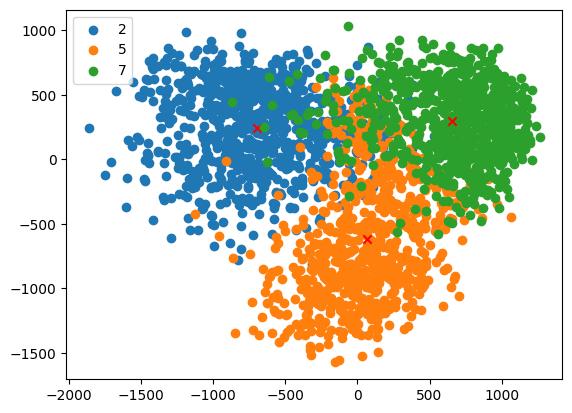

In [361]:
def plot_cluster():
  unique_labels = np.unique(y_train)
  # Calcolo pca per train e test riducendoli a 2 feature
  Zk, U = pca(x_train)
  Zk_test, _ = pca(x_test)


  x_list, y_list = separate_dataset(Zk, y_train)
  x_test_list, y_test_list = separate_dataset(Zk_test, y_test)

  # Calcolo la posizione dei centroidi per ogni cluster nel train
  centroid_list = [centroid(x) for x in x_list]
  print(centroid_list)

  # Create a scatter plot for each unique label
  for label, subdata, c, subdata_test in zip(unique_labels, x_list, centroid_list, x_test_list):
      mask = (y_train == label)
      plt.scatter(Zk[0, mask], Zk[1, mask], label=f'{str(label)[0]}')
      plt.scatter(c[0], c[1], marker='x', color='red')

      # Calcolo la distanza tra il cluster e il centroide di quel cluster
      distance = get_mean_distance(subdata, c)
      distance_test = get_mean_distance(subdata_test, c)
      print(f"Average distance of cluster {str(label)[0]} from centroid: {distance}")
      print(f"Average distance of cluster {str(label)[0]} from test centroid: {distance_test}", end='\n\n')

  # Add a legend to the plot
  plt.legend()
  # Show the plot
  plt.show()
  return centroid_list, [centroid(x) for x in x_test_list], U

centroid_list, test_centroid_list, U = plot_cluster()

In [362]:
def get_accuracy(centroid_list, U):
  xk, U_test = pca(x_test, U=U)
  lables = np.unique(y_test)
  print(lables)

  correct = 0
  for i in range(len(xk.T)):
    distances = [np.linalg.norm(xk[:, i] - c, 2) for c in centroid_list]
    res = lables[np.argmin(distances)]
    if res == y_test[i]:
      correct += 1
  print(f"Accuracy: {correct/len(xk.T)}")

get_accuracy(centroid_list, U)

(784, 591)
New shape of data: (2, 591)
[2 5 7]
Accuracy: 0.8747884940778342


(784, 2360)
New shape of data: (3, 2360)
(784, 591)
New shape of data: (3, 591)
Average distance of cluster 2 from centroid: 1853.461934279966
Average distance of cluster 2 from test centroid: 2088.652891279699

Average distance of cluster 5 from centroid: 1523.7694722287506
Average distance of cluster 5 from test centroid: 2180.3428501643466

Average distance of cluster 7 from centroid: 1257.9085824836693
Average distance of cluster 7 from test centroid: 2487.5473841918497



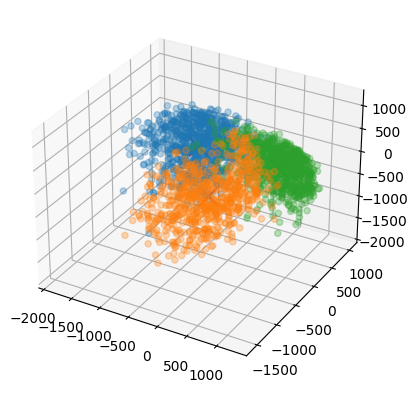

In [363]:
def plot_cluster_3d():
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  # Calcolo pca per train e test riducendoli a 3 feature
  unique_labels = np.unique(y_train)
  Zk, U_3d = pca(x_train, 3)
  Zk_test, _ = pca(x_test, 3)

  x_list, y_list = separate_dataset(Zk, y_train)
  x_test_list, y_test_list = separate_dataset(Zk_test, y_test)

  # Calcolo il centroide per ogni cluster del train set, shape (3,) visto che è calcolato su dati a 3 feature
  centroid_list = [centroid(x) for x in x_list]

  # Create a scatter plot for each unique label
  for label, subdata, c, subdata_test in zip(unique_labels, x_list, centroid_list, x_test_list):
      mask = (y_train == label)
      ax.scatter(Zk[0, mask], Zk[1, mask], Zk[2, mask], label=f'{str(label)[0]}', alpha=0.3)
      ax.scatter(c[0], c[1], c[2], marker='x', color='red', s=200, alpha=1.0)

      # Calcolo la distanza tra il cluster e il centroide di quel cluster
      distance = get_mean_distance(subdata, c)
      distance_test = get_mean_distance(subdata_test, c)
      print(f"Average distance of cluster {str(label)[0]} from centroid: {np.mean(distance)}")
      print(f"Average distance of cluster {str(label)[0]} from test centroid: {np.mean(distance_test)}", end='\n\n')
  return centroid_list, [centroid(x) for x in x_test_list], U_3d

centroid_list, test_centroid_list, U_3d = plot_cluster_3d()

In [364]:
def get_accuracy_3d(centroid_list, U_3d):
  xk, _ = pca(x_test, 3, U_3d)
  lables = np.unique(y_test)
  print(lables)

  correct = 0
  for i in range(len(xk.T)):
    distances = [np.linalg.norm(xk[:, i] - c, 2) for c in centroid_list]
    res = lables[np.argmin(distances)]
    if res == y_test[i]:
      correct += 1
  print(f"Accuracy: {correct/len(xk.T)}")

get_accuracy_3d(centroid_list, U_3d)

(784, 591)
New shape of data: (3, 591)
[2 5 7]
Accuracy: 0.868020304568528


In [ ]:
###### TEST WITH 2 CLUSTER ######

(784, 1539)
New shape of data: (2, 1539)
(784, 385)
New shape of data: (2, 385)
[array([-547.697496  ,   56.30935137]), array([632.84374538, -65.06332617])]
Average distance of cluster 2 from centroid: 1042.5108421335397
Average distance of cluster 2 from test centroid: 1111.1702839698626

Average distance of cluster 5 from centroid: 1271.3496332208158
Average distance of cluster 5 from test centroid: 1394.060391602609



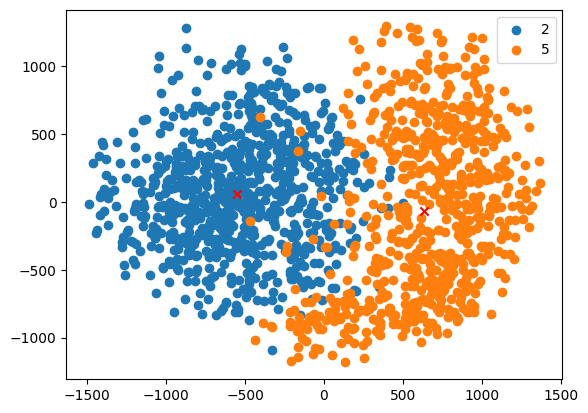

In [350]:
centroid_list, test_centroid_list, U = plot_cluster()

In [351]:
get_accuracy(centroid_list, U)

(784, 385)
New shape of data: (2, 385)
[2 5]
Accuracy: 0.9194805194805195


(784, 1539)
New shape of data: (3, 1539)
(784, 385)
New shape of data: (3, 385)
Average distance of cluster 2 from centroid: 1545.0266962129256
Average distance of cluster 2 from test centroid: 1747.9064379028102

Average distance of cluster 5 from centroid: 1734.1093233578326
Average distance of cluster 5 from test centroid: 1762.5818365558164



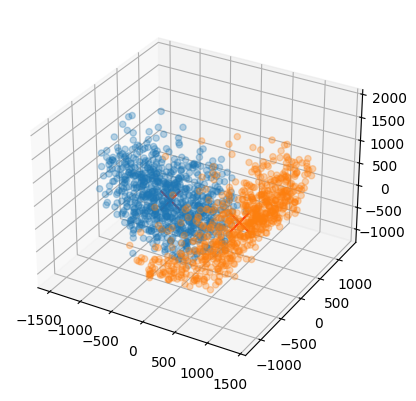

In [352]:
centroid_list, test_centroid_list, U_3d = plot_cluster_3d()

In [353]:
get_accuracy_3d(centroid_list, U_3d)

(784, 385)
New shape of data: (3, 385)
[2 5]
Accuracy: 0.9038961038961039
